# Fit model to data
We will fit a `Polyclonal` model to the RBD antibody mix we simulated.

First, we read in that simulated data.
Recall that we simulated both "exact" and "noisy" data, with several average per-library mutations rates, and at six different concentrations.
Here we analyze the noisy data for the library with an average of 3 mutations per gene, measured at three different concentrations, as this represents a fairly realistic representation of a real experiment:

In [1]:
import requests
import tempfile

import pandas as pd

import polyclonal

noisy_data = (
    pd.read_csv("RBD_variants_escape_noisy.csv", na_filter=None)
    .query('library == "avg3muts"')
    .query("concentration in [0.25, 1, 4]")
    .reset_index(drop=True)
)

noisy_data

,library,barcode,concentration,prob_escape,aa_substitutions,IC90
0,avg3muts,AAAACTGCTGAGGAGA,0.25,0.054700,,0.08212
1,avg3muts,AAAAGCAGGCTACTCT,0.25,0.000000,,0.08212
2,avg3muts,AAAAGCTATAGGTGCC,0.25,0.007613,,0.08212
3,avg3muts,AAAAGGTATTAGTGGC,0.25,0.001363,,0.08212
4,avg3muts,AAAAGTGCCTTCGTTA,0.25,0.000000,,0.08212
...,...,...,...,...,...,...
119995,avg3muts,GAGCATGATCGACGAA,1.00,0.000000,Y508V H519I,0.10830
119996,avg3muts,GAGCATGATCGACGAA,4.00,0.000000,Y508V H519I,0.10830
119997,avg3muts,CTTAAAATAGCTGGTC,0.25,0.000000,Y508W,0.08212
119998,avg3muts,CTTAAAATAGCTGGTC,1.00,0.012260,Y508W,0.08212


For spatial regularization (encouraging epitopes to be structurall proximal residues), we read the inter-residue distances in angstroms from [PDB 6m0j](https://www.rcsb.org/structure/6m0j): 

In [2]:
# we read the PDB from the webpage into a temporary file and get the distances from that.
# you could also just download the file manually and then read from it.
r = requests.get("https://files.rcsb.org/download/6XM4.pdb")
with tempfile.NamedTemporaryFile() as tmpf:
    _ = tmpf.write(r.content)
    tmpf.flush()
    spatial_distances = polyclonal.pdb_utils.inter_residue_distances(tmpf.name, ["A"])

spatial_distances

,site_1,site_2,distance,chain_1,chain_2
0,27,28,1.332629,A,A
1,27,29,4.612508,A,A
2,27,30,8.219518,A,A
3,27,31,11.016782,A,A
4,27,32,13.087037,A,A
...,...,...,...,...,...
548623,1308,1310,30.826773,A,A
548624,1308,1311,75.350853,A,A
548625,1309,1310,12.374796,A,A
548626,1309,1311,115.681534,A,A


Initialize a `Polyclonal` model with these data, including three epitopes.
We know from [prior work](https://www.nature.com/articles/s41467-021-24435-8) the three most important epitopes and a key mutation in each, so we use this prior knowledge to "seed" initial guesses that assign large escape values to a key site in each epitope:

 - site 417 for class 1 epitope, which is often the least important
 - site 484 for class 2 epitope, which is often the dominant one
 - site 444 for class 3 epitope, which is often the second most dominant one

In [3]:
poly_abs = polyclonal.Polyclonal(
    data_to_fit=noisy_data,
    activity_wt_df=pd.DataFrame.from_records(
        [
            ("1", 1.0),
            ("2", 3.0),
            ("3", 2.0),
        ],
        columns=["epitope", "activity"],
    ),
    site_escape_df=pd.DataFrame.from_records(
        [
            ("1", 417, 10.0),
            ("2", 484, 10.0),
            ("3", 444, 10.0),
        ],
        columns=["epitope", "site", "escape"],
    ),
    data_mut_escape_overlap="fill_to_data",
    spatial_distances=spatial_distances,
)

Now fit the `Polyclonal` model, logging output every 100 steps.
Note how the fitting first just fits a site level model to estimate the average effects of mutations at each site, and then fits the full model.
Here we fix the Hill coefficient at one and the non-neutralized fraction at zero:

In [4]:
# NBVAL_IGNORE_OUTPUT
opt_res = poly_abs.fit(
    logfreq=200,
    reg_escape_weight=0.01,
    reg_spatial2_weight=1e-5,
    reg_uniqueness2_weight=0,
    fix_non_neutralized_frac=True,
    fix_hill_coefficient=True,
)

#
# Fitting site-level model.
# Starting optimization of 522 parameters at Sun Feb 26 05:41:55 2023.
        step    time_sec        loss    fit_loss  reg_escape  reg_spread reg_spatial reg_uniqueness reg_uniqueness2 reg_activity reg_hill_coefficient reg_non_neutralized_frac
           0     0.11703      2991.9      2980.2     0.29701           0           0              0               0       11.418                    0                        0
         200      23.205        1876      1836.9      2.3802           0      25.111              0               0       11.569                    0                        0
         308      35.461      1873.6      1835.4      2.3448           0      24.241              0               0       11.592                    0                        0
# Successfully finished at Sun Feb 26 05:42:30 2023.
#
# Fitting model.
# Starting optimization of 5799 parameters at Sun Feb 26 05:42:30 2023.
        step    time_sec        loss    fit_loss  reg_e

We can now visualize the resulting curve fits and activity values and compare them to the "true" activity values used to simulate the data.
Note that the Hill coefficients are one and the non-neutralized fractions are zero because we fixed them as such above:

In [5]:
poly_abs.curve_specs_df.round(2)

,epitope,activity,hill_coefficient,non_neutralized_frac
0,1,1.46,1.0,0.0
1,2,3.19,1.0,0.0
2,3,2.36,1.0,0.0


In [6]:
# NBVAL_IGNORE_OUTPUT
poly_abs.curves_plot()

alt.Chart(...)

In [7]:
# NBVAL_IGNORE_OUTPUT
poly_abs.activity_wt_barplot()

alt.Chart(...)

In [8]:
# NBVAL_IGNORE_OUTPUT

import altair as alt

true_activities = pd.read_csv("RBD_activity_wt_df.csv")


activity_wt_comparison = (
    pd.concat(
        [
            poly_abs.activity_wt_df.rename(columns={"activity": "predicted"}),
            true_activities.rename(columns={"activity": "actual"}).drop(
                columns="epitope"
            ),
        ],
        axis=1,
    )
).melt(
    id_vars=["epitope"],
    value_vars=["actual", "predicted"],
    var_name="value_type",
    value_name="wildtype activity",
)

alt.Chart(activity_wt_comparison).mark_bar(size=35).encode(
    x="value_type:O",
    y="wildtype activity:Q",
    color=alt.Color(
        "epitope:N", scale=alt.Scale(range=list(poly_abs.epitope_colors.values()))
    ),
    column="epitope:N",
    tooltip=["value_type", alt.Tooltip("wildtype activity", format=".3f"), "epitope"],
).properties(width=100, height=125)

alt.Chart(...)

Similarly, we can visualize the resulting fits for the escape values, and compare them to the "true" escape values used to simulate the data.
Note how entries can be filtered by how many variants a mutation is seen in (`times_seen`):

In [9]:
# NBVAL_IGNORE_OUTPUT
poly_abs.mut_escape_plot()

alt.VConcatChart(...)

For these simulated data, we can also see how well the fit model does on the "true" simulated values from a library with a different (higher) mutation rate.
We therefore read in the "exact" simulated data from a library with a different mutation rate:

In [10]:
exact_data = (
    pd.read_csv("RBD_variants_escape_exact.csv", na_filter=None)
    .query('library == "avg3muts"')
    .query("concentration in [0.25, 1, 0.5]")
    .reset_index(drop=True)
)

We will compare the true simulated IC90 values to those predicted by the fit model.
We make the comparison on a log scale, and clip IC90s at values >50 as likely to be way outside the dynamic range given the concentrations used:

Correlation (R^2) is 0.97


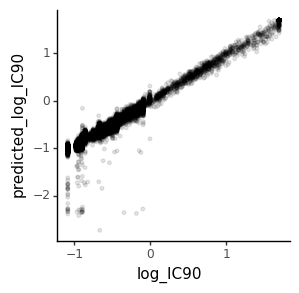

In [11]:
# NBVAL_IGNORE_OUTPUT

import numpy

from plotnine import *

max_ic90 = 50

# we only need the variants, not the concentration for the IC90 comparison
ic90s = (
    exact_data[["aa_substitutions", "IC90"]]
    .assign(IC90=lambda x: x["IC90"].clip(upper=max_ic90))
    .drop_duplicates()
)

ic90s = poly_abs.icXX(ic90s, x=0.9, col="predicted_IC90", max_c=max_ic90)

ic90s = ic90s.assign(
    log_IC90=lambda x: numpy.log10(x["IC90"]),
    predicted_log_IC90=lambda x: numpy.log10(x["predicted_IC90"]),
)

corr = ic90s["log_IC90"].corr(ic90s["predicted_log_IC90"]) ** 2
print(f"Correlation (R^2) is {corr:.2f}")

ic90_corr_plot = (
    ggplot(ic90s)
    + aes("log_IC90", "predicted_log_IC90")
    + geom_point(alpha=0.1, size=1)
    + theme_classic()
    + theme(figure_size=(3, 3))
)

_ = ic90_corr_plot.draw()
# ic90_corr_plot.save('IC90_pred_vs_actual.pdf', height=3.5, width=3.5)

Next we see how well the model predicts the variant-level escape probabilities $p_v\left(c\right)$, by reading in exact data from the simulations, and then making predictions of escape probabilities.
We both examine and plot the correlations:

In [12]:
# NBVAL_IGNORE_OUTPUT

exact_vs_pred = poly_abs.prob_escape(variants_df=exact_data)

print(f"Correlations (R^2) at each concentration:")
display(
    exact_vs_pred.groupby("concentration")
    .apply(lambda x: x["prob_escape"].corr(x["predicted_prob_escape"]) ** 2)
    .rename("correlation (R^2)")
    .reset_index()
    .round(2)
)

pv_corr_plot = (
    ggplot(exact_vs_pred)
    + aes("prob_escape", "predicted_prob_escape")
    + geom_point(alpha=0.1, size=1)
    + facet_wrap("~ concentration", nrow=1)
    + theme_classic()
    + theme(figure_size=(3 * exact_vs_pred["concentration"].nunique(), 3))
)

_ = pv_corr_plot.draw()

Correlations (R^2) at each concentration:


,concentration,correlation (R^2)
0,0.25,0.99
1,0.50,1.00
2,1.00,1.00


We also examine the correlation between the "true" and inferred mutation-escape values, $\beta_{m,e}$.
In general, it's necessary to ensure the epitopes match up for this type of comparison as it is arbitrary which epitope in the model is given which name.
But above we seeded the epitopes at the site level using `site_effects_df` when we initialized the `Polyclonal` object, so they match up with class 1, 2, and 3:

In [13]:
# NBVAL_IGNORE_OUTPUT

import altair as alt

mut_escape_pred = pd.read_csv("RBD_mut_escape_df.csv").merge(
    (
        poly_abs.mut_escape_df.assign(
            epitope=lambda x: "class " + x["epitope"].astype(str)
        ).rename(columns={"escape": "predicted escape"})
    ),
    on=["mutation", "epitope"],
    validate="one_to_one",
)

print("Correlation (R^2) between predicted and true values:")
corr = (
    mut_escape_pred.groupby("epitope")
    .apply(lambda x: x["escape"].corr(x["predicted escape"]) ** 2)
    .rename("correlation (R^2)")
    .reset_index()
)
display(corr.round(2))

# for testing since we nbval ignore cell output
assert (
    numpy.allclose(
        corr["correlation (R^2)"], numpy.array([0.60, 0.96, 0.95]), atol=0.02
    )
    == True
)

corr_chart = (
    alt.Chart(mut_escape_pred)
    .encode(
        x="escape",
        y="predicted escape",
        color=alt.Color(
            "epitope", scale=alt.Scale(range=list(poly_abs.epitope_colors.values()))
        ),
        tooltip=["mutation", "epitope"],
    )
    .mark_point(opacity=0.5)
    .properties(width=250, height=250)
    .facet(column="epitope")
    .resolve_scale(
        x="independent",
        y="independent",
    )
)

corr_chart

Correlation (R^2) between predicted and true values:


,epitope,correlation (R^2)
0,class 1,0.60
1,class 2,0.96
2,class 3,0.95


alt.FacetChart(...)

The correlations are strongest for the dominant epitope (class 2), which makes sense as this will drive the highest escape signal.